# 5. Gyakorlat: $Q$-tanulás
OpenAI gym telepítése:

In [12]:
%pip install gym
%pip install pygame

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Könyvtárak
import os
import gym
import random
import warnings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.signal import fftconvolve

# Konfigurációk
seed = 0
np.random.seed(seed)
random.seed(seed)
%matplotlib inline
matplotlib.rc('animation', html='jshtml')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')

## Segédfüggvények

In [14]:
# Jeleneti változó inicializálása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Képkockák lejátszása egymás után
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Mozgóátlagolás (gyors Fourier-transzformáció konvolúcióval)
def window_avg(lst, window_size):
    window_size = int(window_size)
    kernel = np.ones(window_size) / window_size
    return fftconvolve(lst, kernel, mode='valid')

---
## Környezet

In [15]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array')

print(f"Cselekvések tere (A): {env.action_space}")
print(f'Állapotok tere: {env.observation_space}')

# Cselekvések társítása kiíratási műveletekhez
action_mapping = {
    0: "←",
    1: "↓",
    2: "→",
    3: "↑"
}

A = list(action_mapping.keys())  # Cselekvési tér

Cselekvések tere (A): Discrete(4)
Állapotok tere: Discrete(16)


---
## Ügynök

A kezdeti ügynök egy véletlen ügynök: $a_t \sim A$

In [16]:
def RandomAgent(s):
    return np.random.choice(A)

---
## Egy epizód véletlen ügynökkel

In [17]:
s = env.reset()[0]  # Környezet inicializálása
r_track = []  # Jutalmak követése 
frames = []  # Képkockák követése animáláshoz
done = False  # Az epizód befejeződött? True: az ügynök meghalt vagy sikeresen beért a célba
frame = None  # Képkocka változó
while not done:
    a = RandomAgent(s)  # Cselekvés választása az állapot alapján
    sp, r, done, info, _ = env.step(a)  # Cselekvés végrehajtása a környezetben
    r_track.append(r)  # Jutalom hozzáadása a követéshez
    frame = env.render()  # Környezet állapotának lerenderelése egy RGB képpé
    frames.append(frame)  # Képkocka hozzáadása a követéshez
    print(f"s: {s},\ta: {action_mapping[a]},\tsp: {sp},\tr: {r}")
    s = sp

env.close()

s: 0,	a: ←,	sp: 0,	r: 0.0
s: 0,	a: ↑,	sp: 0,	r: 0.0
s: 0,	a: ↓,	sp: 1,	r: 0.0
s: 1,	a: ←,	sp: 0,	r: 0.0
s: 0,	a: ↑,	sp: 1,	r: 0.0
s: 1,	a: ↑,	sp: 0,	r: 0.0
s: 0,	a: ↑,	sp: 1,	r: 0.0
s: 1,	a: ↑,	sp: 2,	r: 0.0
s: 2,	a: ↓,	sp: 1,	r: 0.0
s: 1,	a: ↑,	sp: 0,	r: 0.0
s: 0,	a: ↓,	sp: 0,	r: 0.0
s: 0,	a: →,	sp: 0,	r: 0.0
s: 0,	a: ←,	sp: 0,	r: 0.0
s: 0,	a: ↑,	sp: 0,	r: 0.0
s: 0,	a: →,	sp: 1,	r: 0.0
s: 1,	a: ←,	sp: 0,	r: 0.0
s: 0,	a: ←,	sp: 0,	r: 0.0
s: 0,	a: ←,	sp: 4,	r: 0.0
s: 4,	a: →,	sp: 0,	r: 0.0
s: 0,	a: ↓,	sp: 1,	r: 0.0
s: 1,	a: →,	sp: 5,	r: 0.0


In [18]:
plot_animation(frames, repeat=True, interval=100)

---
## $Q$-tanulás
### $\varepsilon$-mohó $Q$-ügynök

In [19]:
def QLAgent(Q, eps, s):
    p = np.random.random()
    if p < eps:
        return np.random.choice(A)
    else:
        return np.argmax(Q[s])

## $Q$-tanítás

In [20]:
max_i = 100000
gamma = 0.98
alpha = 0.05
eps_start = 0.99
eps_end = 0.0
eps_decay = 0.99995
eps = eps_start
r_track = []
r_track_mean = []

Q = [[np.random.randn() for _ in range(env.action_space.n)] for _ in range(env.observation_space.n)] # Q-tábla inicializálása
Q[env.observation_space.n - 1][:] = [0 for _ in range(env.action_space.n)] # Terminális állapot cselekvés-értékének kinullázása

for i in range(max_i):
    s = env.reset()[0]
    done = False
    r_sum = 0

    while not done:
        a = QLAgent(Q, eps, s)
        sp, r, done, info, _ = env.step(a)  # Cselekvés végrehajtása a környezetben
        Q[s][a] = Q[s][a] + alpha * (r + gamma * max(Q[sp]) - Q[s][a])
        r_sum += r
        s = sp
    
    eps = eps * eps_decay if eps > eps_end else eps_end
    r_track.append(r_sum)
    r_track_mean.append(np.mean(r_track))

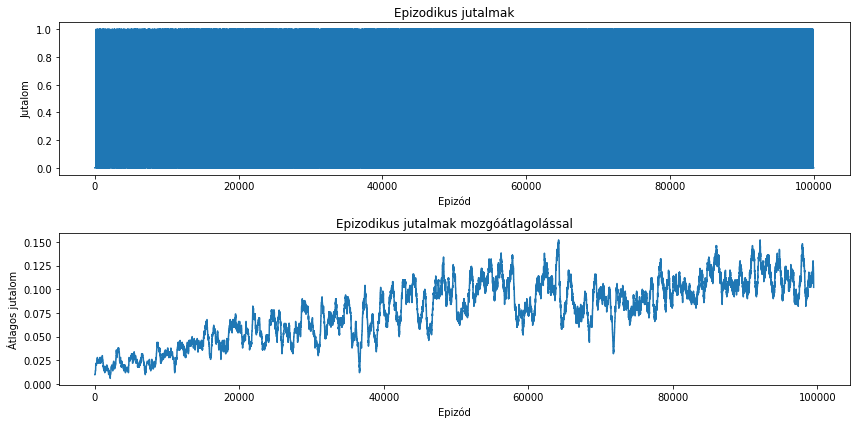

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.set_title('Epizodikus jutalmak')
ax1.plot(r_track)
ax1.set_ylabel('Jutalom')
ax1.set_xlabel('Epizód')

ax2.set_title('Epizodikus jutalmak mozgóátlagolással')
ax2.plot(window_avg(r_track, len(r_track) / 200))
ax2.set_xlabel('Epizód')
ax2.set_ylabel('Átlagos jutalom')

plt.tight_layout()
plt.show()

In [24]:
frames = []
done = False
s = env.reset()[0]
while not done:
    a = QLAgent(Q, 0.0, s)
    sp, r, done, info, _ = env.step(a)
    frames.append(env.render()) 
    s = sp

plot_animation(frames,)

## Dupla $Q$-tanulás